Import things

In [274]:
import cv2
import numpy as np
import glob
import time
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

Helper plotting functions

In [68]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(im1)
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    ax2.imshow(im2)
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

Feature extraction functions

In [394]:
# Return HOG features and visualization for an image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:  # Call with two outputs if vis==True
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Returns binned color features for an image
def get_bin_spatial_features(img, size=(16, 16)):
    # Resize the image, and then flatten it out into a feature vector
    return cv2.resize(img, size).ravel()


# Returns the color histogram features for an image
def get_color_hist_features(img, nbins=32, bins_range=(0, 256)):
    ''' NEED TO CHANGE bins_range if reading .png files with mpimg! '''
    
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)[0]
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)[0]
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)[0]
    
    # Concatenate the histograms into a single feature vector
    return np.concatenate((ch1_hist, ch2_hist, ch3_hist))


# This function will take a list of img file names and turn it into a list of image features for the classifier
def extract_features(imgs, color_space='HSV', spatial_size=(16,16), hist_bins=32,
                     orient=8, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', precomputed_hog=None,
                     use_spatial_features=True, use_color_hist_features=True, use_hog_features=True):
    ''' "imgs" can be paths or loaded images '''
    
    features = []  # List to append feature vectors to
    for img in imgs:
        img_features = []
        if type(img) is str:
            image = mpimg.imread(img)
            if img.endswith('.png'):
                image = image*255
        else:
            image = img
            
        img_size = (64, 64)
        if image.shape[:2] != img_size:
            image = cv2.resize(image, img_size)
        if precomputed_hog is not None and precomputed_hog.shape[:2] != img_size:
            precomputed_hog = cv2.resize(precomputed_hog, img_size)
        
        # Color Conversion
        original_image = np.copy(image)
        if color_space == 'RGB':
            image = np.copy(image)
        else:
            color = eval('cv2.COLOR_RGB2{}'.format(color_space))
            image = cv2.cvtColor(image, color)

        # Spatial Features
#         t = time.time()
        if use_spatial_features == True:
            spatial_features = get_bin_spatial_features(original_image, size=spatial_size)
#             print(np.max(p.absolute(spatial_features)))
            img_features.append(spatial_features)
#         print(time.time() - t, 'to get spatial features')
            
        # Color Histogram Features
#         t = time.time()
        if use_color_hist_features == True:
            hist_features = get_color_hist_features(image, nbins=hist_bins)/255
#             print(np.max(np.absolute(hist_features)))
            img_features.append(hist_features)
#         print(time.time() - t, 'to get color hist features')
            
        # HOG Features
#         t = time.time()
        if use_hog_features == True:
            if precomputed_hog is not None:
#                 print('hog length:', len(precomputed_hog))
                img_features.append(precomputed_hog*255)
            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(image.shape[2]):
                        hog_features.append(get_hog_features(
                            image[:,:,channel], 
                            orient,
                            pix_per_cell,
                            cell_per_block, 
                            vis=False,
                            feature_vec=True
                        ))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = get_hog_features(
                        image[:,:,hog_channel],
                        orient, 
                        pix_per_cell,
                        cell_per_block,
                        vis=False,
                        feature_vec=True
                    )

    #             print(np.max(np.absolute(hog_features)))
#                 print('hog length:', len(hog_features))
                img_features.append(hog_features*255)
#         print(time.time() - t, 'to get hog features')
            
        # Add this image's features to the master list
        features.append(np.concatenate(img_features))
        
    if len(imgs) == 1:
        return np.array(features)
    
    return features

Train the SVM classifier

Extracting features from 17760 images...
Took 69.16 seconds to extract 17760 image features
shape (17760, 5568)
min, max scaled: -1.71933234687 52.3903960749
Training SVC...
Took 13.26 seconds to train SVC...
Test accuracy of SVC: 0.991


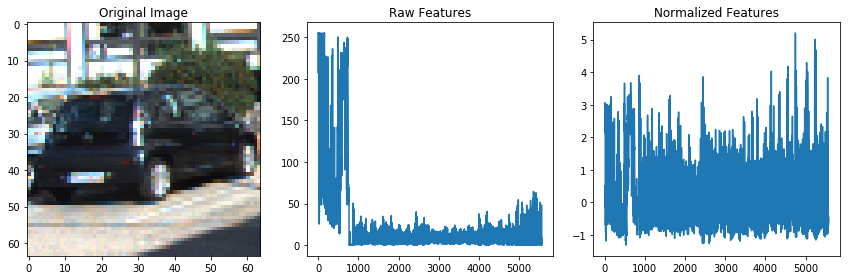

In [379]:
vehicle_img_paths = shuffle(glob.glob('./vehicles/*/*.png'))#[:500]
nonvehicle_img_paths = shuffle(glob.glob('./non-vehicles/*/*.png'))#[:500]

n_imgs = len(vehicle_img_paths) + len(nonvehicle_img_paths)

# Extract vehicle and non-vehicle image features
print('Extracting features from {} images...'.format(n_imgs))
t = time.time()
vehicle_features = extract_features(vehicle_img_paths)
nonvehicle_features = extract_features(nonvehicle_img_paths)

t2 = time.time()
print('Took', round(t2-t, 2), 'seconds to extract', n_imgs, 'image features')

x = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)
print('shape', x.shape)
scaler = StandardScaler().fit(x)
scaled_x = scaler.transform(x)  # Normalize the features
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))  # Labels vector

min_scaled = np.min(scaled_x)
max_scaled = np.max(scaled_x)
print('min, max scaled:', min_scaled, max_scaled)

# Shuffle and train/test split
rand = random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.25, random_state=rand)

# Train the SVC
print('Training SVC...')
svc = LinearSVC()
t = time.time()  # Track the training time
svc.fit(x_train, y_train)
t2 = time.time()
print('Took', round(t2-t, 2), 'seconds to train SVC...')

# Measure SVC accuracy
print('Test accuracy of SVC:', round(svc.score(x_test, y_test), 3))

# Plot an example of raw and scaled features
car_ind = random.randint(0, len(vehicle_img_paths))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(vehicle_img_paths[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(x[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_x[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

Sliding window search for cars in driving image

448 windows


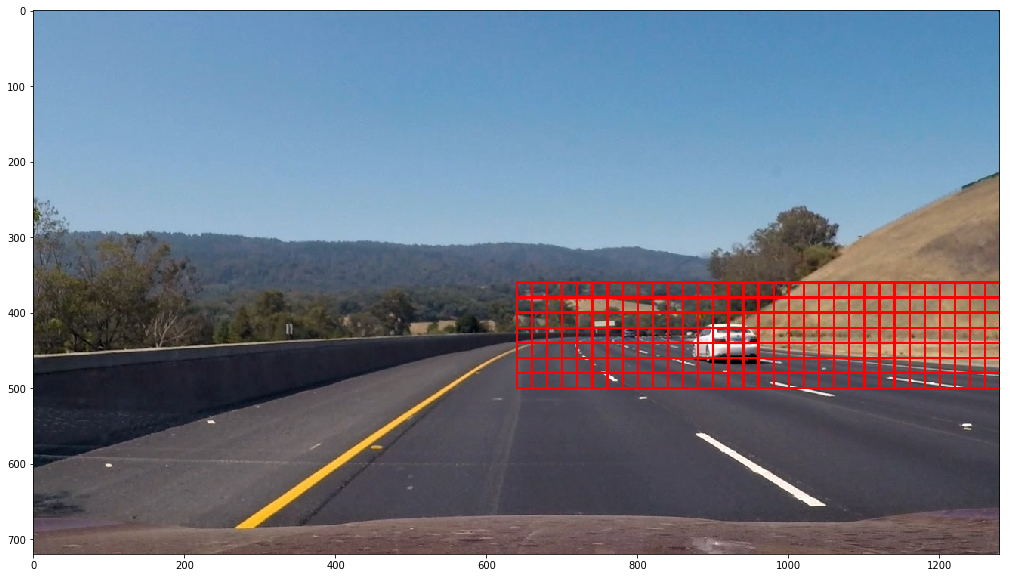

In [434]:
# Returns the list of windows to search through and the still-shaped hog for the entire image
def get_windows(img, sizes=[128, 180, 256], overlap=.75, y_start_stop=(.5, .92), x_start_stop=(.5, 1)):
    ''' "sizes" are the square dimensions of the windows we will tile
        "y_start_stop" and "x_stop_stop" are passed in as percentages of the image '''
    
    y_size, x_size = img.shape[:2]
    
    x_start = int(x_start_stop[0]*x_size)
    x_stop = int(x_start_stop[1]*x_size)
    y_start = int(y_start_stop[0]*y_size)
    y_stop = int(y_start_stop[1]*y_size)
    
    windows = []  # windows will be stored in this array as a tuple of tuples representing top-left and bottom-right window coordinates
    for size in sizes:
        step = int(size*(1-overlap))
        for y in range(y_start, y_stop-size, step):
            for x in range(x_start, x_stop-size, step):  # Windows tiled from the left
                windows.append(((x, y), (x+size, y+size)))
            for x in range(x_stop, x_start+size, -step):  # Windows tiled from the right
                windows.append(((x-size, y), (x, y+size)))
               
    '''
    if hog_channel is None: return windows
          
    hog_features = []
    if hog_channel == 'ALL':
        for channel in range(img.shape[2]):
            hog_features.append(get_hog_features(
                img[:,:,channel], 
                orient,
                pix_per_cell,
                cell_per_block, 
                vis=False,
                feature_vec=False
            ))
    else:
        hog_features.append(get_hog_features(
            image[:,:,hog_channel],
            orient, 
            pix_per_cell,
            cell_per_block,
            vis=False,
            feature_vec=False
        ))
    '''
            
    return windows
    
    
# Draws bounding boxes
def draw_boxes(img, boxes, color=(0, 0, 255), thickness=4):
    imcopy = np.copy(img)
    for box in boxes:
        cv2.rectangle(imcopy, box[0], box[1], color, thickness)
        
    return imcopy


image = mpimg.imread('./test_images/test3.jpg')
draw_img = np.copy(image)
boxes_2 = get_windows(image, sizes=[80], y_start_stop=(.5, .7))
# boxes_3 = get_windows(image, sizes=[120])
# boxes_4 = get_windows(image, sizes=[180])
draw_img = draw_boxes(draw_img, boxes_2, color=(255, 0, 0), thickness=2)
# draw_img = draw_boxes(draw_img, boxes_3, color=(0, 255, 0), thickness=4)
# draw_img = draw_boxes(draw_img, boxes_4, color=(255, 0, 255), thickness=6)
windows = np.concatenate((boxes_2))
# windows = np.concatenate((boxes_2, boxes_3))
# windows = np.concatenate((boxes_2, boxes_3, boxes_4))
print(len(windows), 'windows')
# draw_img = draw_boxes(draw_img, windows)
big_plot(draw_img)

542 windows


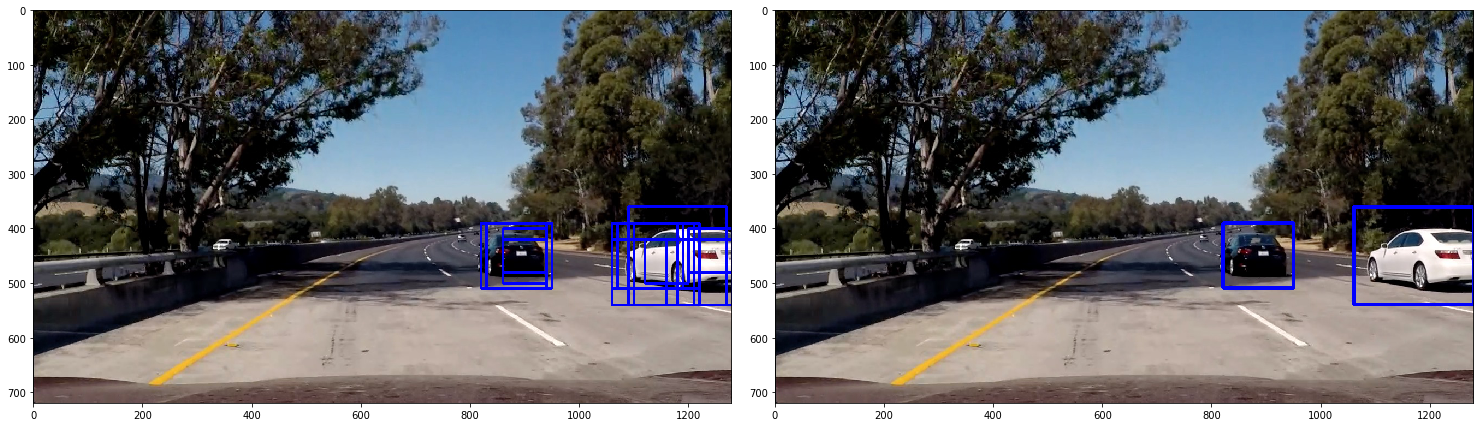

In [442]:
# Returns boolean for whether the window of the given image contains a car
def contains_car(img, window):
    top_left, bottom_right = window[0], window[1]
    sub_img = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    
    features = extract_features([sub_img])
    scaled_features = scaler.transform(features)  # Normalize the features
    scaled_features = np.clip(scaled_features, min_scaled, max_scaled)  # Was getting a single HUGE value, so clipping
    
    return svc.predict(scaled_features) == 1
    

def get_heatmap(img, boxes, thresholded=False):
    heatmap = np.zeros_like(img[:,:,0])
    for box in boxes:
        top_left, bottom_right = box[0], box[1]
        heatmap[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] += 1
    
    if thresholded: return threshold_heatmap(heatmap)
    
    return heatmap


def threshold_heatmap(heatmap, threshold=2):
    heatmap[heatmap < threshold] = 0
    return heatmap


def get_aggregate_heatmap(thresholded=True, threshold=4):
    global prev_heatmaps
    
    heatmaps = np.array(prev_heatmaps)
    
    if not thresholded: return np.sum(heatmaps, axis=0)
    
    return threshold_heatmap(np.sum(heatmaps, axis=0), threshold=threshold)


def draw_heatmap_boxes(img, heatmap):
    label_img, n_items = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, n_items+1):
        # Find pixels with each car_number label value
        nonzero = (label_img == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
        
    return img

    
image = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(image)
windows_1 = get_windows(image, sizes=[80], overlap=.75, y_start_stop=(.5, .7))
windows_2 = get_windows(image, sizes=[120, 180], overlap=.75)
windows = windows_1 + windows_2
print(len(windows), 'windows')
car_windows = []
for window in windows:
    if contains_car(image, window):
        car_windows.append(window)
draw_img = draw_boxes(draw_img, car_windows)
heatmap = get_heatmap(image, car_windows, thresholded=False)
side_by_side_plot(draw_img, draw_heatmap_boxes(np.copy(image), heatmap))

In [447]:
prev_heatmaps = []

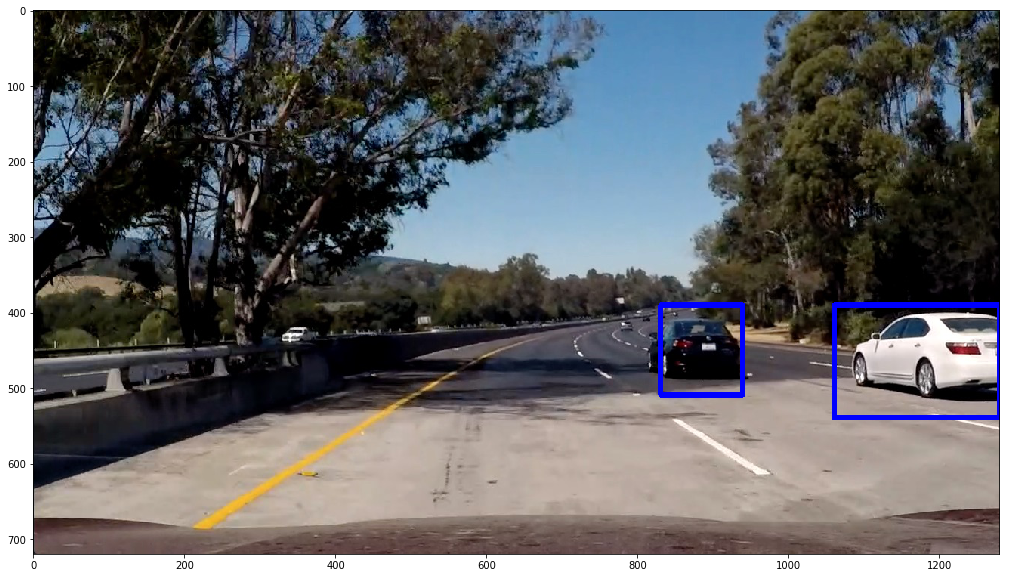

In [450]:
# prev_heatmaps = []

def find_cars(image):
    global prev_heatmaps
    
    windows_1 = get_windows(image, sizes=[80], overlap=.75, y_start_stop=(.5, .7))
    windows_2 = get_windows(image, sizes=[120, 180], overlap=.75)
    windows = windows_1 + windows_2
    car_windows = []
    for window in windows:
        if contains_car(image, window):
            car_windows.append(window)
            
    heatmap = get_heatmap(image, car_windows, thresholded=False)
    prev_heatmaps.insert(0, heatmap)
    if len(prev_heatmaps) > 5:
        prev_heatmaps.pop()
    aggregate_heatmap = get_aggregate_heatmap(threshold=4)
    
    return draw_heatmap_boxes(np.copy(image), aggregate_heatmap)

image = mpimg.imread('./test_images/test5.jpg')
big_plot(find_cars(image))

In [307]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [451]:
prev_heatmaps = []

f_name = 'test_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(find_cars)  # Pipe the video frames through the car-detection pipeline
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

[MoviePy] >>>> Building video ./videos_out/test_video.mp4
[MoviePy] Writing video ./videos_out/test_video.mp4



 97%|█████████▋| 38/39 [01:24<00:02,  2.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos_out/test_video.mp4 

CPU times: user 1min 24s, sys: 351 ms, total: 1min 24s
Wall time: 1min 25s


In [452]:
prev_heatmaps = []

f_name = 'project_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(find_cars)  # Pipe the video frames through the car-detection pipeline
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

[MoviePy] >>>> Building video ./videos_out/project_video.mp4
[MoviePy] Writing video ./videos_out/project_video.mp4


100%|█████████▉| 1260/1261 [46:13<00:02,  2.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos_out/project_video.mp4 

CPU times: user 45min 59s, sys: 7.78 s, total: 46min 7s
Wall time: 46min 14s
